In [11]:
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
# trips.txt: there are multiple trips per shuttle

df_trips = pd.read_csv('./google_transit/trips.txt')
df_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,777,48686.126106,670294,NaN,NaN,NaN,23714,48686,0,0
1,777,48686.126106,670295,NaN,NaN,NaN,23714,48686,0,0
2,777,48686.126106,670296,NaN,NaN,NaN,23714,48686,0,0
3,777,48686.126106,670297,NaN,NaN,NaN,23714,48686,0,0
4,777,48686.126106,670298,NaN,NaN,NaN,23714,48686,0,0
...,...,...,...,...,...,...,...,...,...,...
333,5707,48152.126137,670590,SEC Express,NaN,NaN,23728,48700,0,0
334,5707,48152.124657,670598,SEC Express,NaN,NaN,23727,48700,0,0
335,5707,48152.124657,670599,SEC Express,NaN,NaN,23727,48700,0,0
336,5707,48152.124657,670600,SEC Express,NaN,NaN,23728,48700,0,0


In [10]:
# shapes.txt: points that make the routes
df_shapes = pd.read_csv('./google_transit/shapes.txt')
df_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,48686,42.381867,-71.125325,1
1,48686,42.380436,-71.124350,2
2,48686,42.380421,-71.124387,3
3,48686,42.380187,-71.124944,4
4,48686,42.380167,-71.124994,5
...,...,...,...,...
5619,48700,42.362642,-71.124582,285
5620,48700,42.362604,-71.124607,286
5621,48700,42.362566,-71.124630,287
5622,48700,42.362443,-71.124688,288


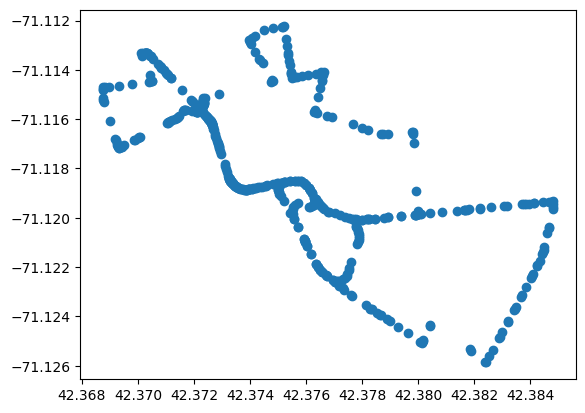

In [15]:
shape = df_shapes[df_shapes['shape_id']==48686]
lat = list(shape['shape_pt_lat'])
long = list(shape['shape_pt_lon'])
plt.scatter(x=lat, y=long)